In [1]:
import pandas as pd
from sklearn import preprocessing
from neupy import environment
from sklearn.model_selection import train_test_split
from neupy import environment
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

%matplotlib inline

#### Select original the training records for discovery

In [2]:
train_df = pd.read_csv("data/train_70.0.csv")
target_training = train_df.loc[:,"shares"]

FileNotFoundError: File b'data/train_70.0.csv' does not exist

#### Data discovery - relation between no of shares and the day of the week

In [3]:
day_of_week_columns = [" weekday_is_monday", " weekday_is_tuesday", " weekday_is_wednesday"," weekday_is_thursday"," weekday_is_friday"," weekday_is_saturday", " weekday_is_sunday"]
share_by_weekday = [0]*len(day_of_week_columns)
print(train_df.shape)
for idx, row in train_df.iterrows():
    for day_no, day_of_week_column in enumerate(day_of_week_columns):
        if row[day_of_week_column] == 1:
            share_by_weekday[day_no] += row["shares"]
            
print(share_by_weekday)

(27750, 62)
[16965029, 16083831, 16835516, 15912807, 13505688, 7176474, 7130078]


Text(0.5,1,'Distribution of shares by day of week')

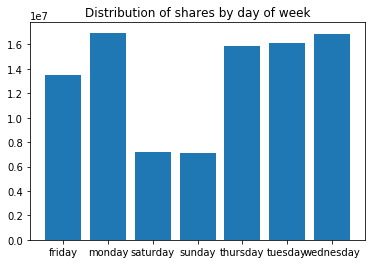

In [4]:


weekday_names = [day_of_week_column.replace(" weekday_is_", "") for day_of_week_column in day_of_week_columns]
plt.bar(weekday_names, share_by_weekday)
plt.title("Distribution of shares by day of week")

[5592887, 14892053, 12889454, 6144253, 16071719, 13340303]


Text(0.5,1,'Distribution of shares by channel')

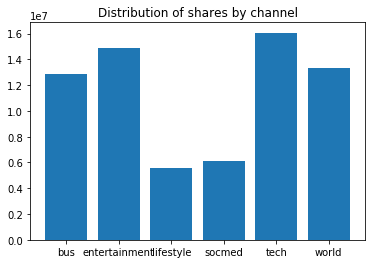

In [5]:
data_channel_columns = [" data_channel_is_lifestyle", " data_channel_is_entertainment", " data_channel_is_bus", " data_channel_is_socmed", " data_channel_is_tech", " data_channel_is_world"]
share_by_channel = [0]*len(data_channel_columns)

for idx, row in train_df.iterrows():
    for day_no, data_channel_column in enumerate(data_channel_columns):
        if row[data_channel_column] == 1:
            share_by_channel[day_no] += row["shares"]
            
print(share_by_channel)

channel_names = [data_channel_column.replace(" data_channel_is_", "") for data_channel_column in data_channel_columns]
plt.bar(channel_names, share_by_channel)
plt.title("Distribution of shares by channel")

### Train a NN model using neupy

### Approach and code taken from [here](http://neupy.com/apidocs/neupy.algorithms.rbfn.grnn.html) 

In [3]:
training_df = pd.read_csv("data/train_70.0_updated.csv")
training_X = training_df.loc[:, training_df.columns != " shares"]
training_Y = training_df.loc[:, " shares"]

test_df = pd.read_csv("data/test_30_updated.csv")
testing_X = test_df.loc[:, test_df.columns != " shares"]
testing_Y = test_df.loc[:, " shares"]

print("Training shapes")
print(training_X.shape)
print(training_Y.shape)

print("Testing shapes")
print(testing_X.shape)
print(testing_Y.shape)

Training shapes
(27750, 27)
(27750,)
Testing shapes
(11894, 27)
(11894,)


In [4]:
data_scaler = preprocessing.MinMaxScaler()

columns_to_scale = [" n_tokens_title", " n_tokens_content", " num_hrefs", " num_self_hrefs", " num_imgs", " num_videos", " average_token_length", " num_keywords", " kw_avg_min"," kw_avg_max", " kw_avg_avg"," self_reference_avg_sharess"]
training_X.loc[:, columns_to_scale] = data_scaler.fit_transform(training_X.loc[:, columns_to_scale])
training_Y = data_scaler.fit_transform(training_Y.reshape(-1, 1))

testing_X.loc[:, columns_to_scale] = data_scaler.fit_transform(testing_X.loc[:, columns_to_scale])
testing_Y = data_scaler.fit_transform(testing_Y.reshape(-1, 1))

G:\anaconda\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
G:\anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
G:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
G:\anaconda\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [5]:
print(training_X.shape)
print(testing_X.shape)

(27750, 27)
(11894, 27)


### GRNN

### NeuPy imports

In [6]:
from neupy import algorithms, layers, estimators

environment.reproducible()

In [11]:
nw = algorithms.GRNN(std=0.3, verbose=False)
nw.train(training_X, training_Y)
y_predicted = nw.predict(testing_X)
print(estimators.rmse(y_predicted, testing_Y))

0.01553372665011385


#### Get the RMSE for different values of STD

In [8]:
std_values = [0.06 + 0.02 * x for x in range(5)]
rmse_training = []
rmse_testing = []
for std_value in std_values:
    nw = algorithms.GRNN(std=std_value, verbose=True)
    nw.train(training_X, training_Y)
    testing_Y_predicted = nw.predict(testing_X)
    rmse_testing.append(estimators.rmse(testing_Y_predicted, testing_Y))



Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] std = 0.06


Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] std = 0.08


Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] std = 0.1


Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] std = 0.12


Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch

#### Generate the validation curves

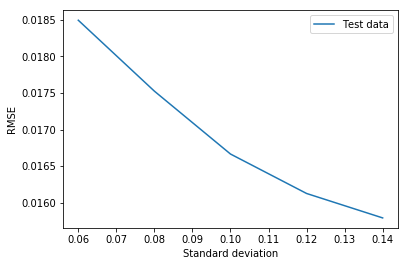

In [10]:
generate_rmse_curves_testing_training_data(std_values, rmse_testing, rmse_training, "RMSE with standard deviation", "Standard deviation")

### Invert the target values using [this](https://stackoverflow.com/questions/41551165/invert-minmaxscaler-from-scikit-learn)

In [12]:
y_predicted_upscaled = data_scaler.inverse_transform(y_predicted)
testing_Y_upscaled = data_scaler.inverse_transform(testing_Y)

### Check the predicted values

In [12]:
slice = 100
for itr in range(slice):
    print("#{0}. Diff={1}".format(itr, abs(y_predicted_upscaled[itr] - testing_Y_upscaled[itr])))

#0. Diff=[1290.89548681]
#1. Diff=[944.15984776]
#2. Diff=[16071.0015258]
#3. Diff=[514.39948712]
#4. Diff=[15838.6004488]
#5. Diff=[1154.60599213]
#6. Diff=[3647.21293788]
#7. Diff=[295.10553786]
#8. Diff=[383.55702558]
#9. Diff=[2279.62215478]
#10. Diff=[3493.67788242]
#11. Diff=[3999.95134365]
#12. Diff=[16309.93409339]
#13. Diff=[4580.0040625]
#14. Diff=[1371.68037944]
#15. Diff=[1740.82161519]
#16. Diff=[4229.96199357]
#17. Diff=[560.27674053]
#18. Diff=[1978.80975366]
#19. Diff=[838.72333133]
#20. Diff=[133309.33855459]
#21. Diff=[2008.25303324]
#22. Diff=[2688.78363661]
#23. Diff=[1516.74625832]
#24. Diff=[3699.99755283]
#25. Diff=[2187.78783993]
#26. Diff=[1379.57390628]
#27. Diff=[230.60273462]
#28. Diff=[1214.53274272]
#29. Diff=[817.56162325]
#30. Diff=[2238.60482879]
#31. Diff=[1835.76871171]
#32. Diff=[349.61808355]
#33. Diff=[1641.44742993]
#34. Diff=[101.90641847]
#35. Diff=[73.87574518]
#36. Diff=[1751.02214333]
#37. Diff=[403.23643598]
#38. Diff=[3454.66326129]
#39. Di

### MLFF BP with conjugate gradient

In [13]:
environment.reproducible()
from neupy import algorithms, layers

cgnet = algorithms.ConjugateGradient(
    connection=[
        layers.Input(training_X.shape[1]),
        layers.Sigmoid(50),
        layers.Sigmoid(1),
    ],
    search_method='golden',
    show_epoch=1,
    verbose=True,
    addons=[algorithms.LinearSearch],
)


Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.49 seconds


#### Note: table below shows MSE - need to take sqrt to get the RMSE


Start training

[TRAINING DATA] shapes: (27750, 27)
[TEST DATA] shapes: (11894, 27)
[TRAINING] Total epochs: 5

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |  0.00025035 |  0.00024234 |       05:44 |
|           2 |  0.00025015 |  0.00024287 |       07:35 |
|           3 |  0.00024959 |  0.00024329 |       07:54 |
|           4 |  0.00024895 |  0.00024192 |       06:54 |
|           5 |  0.00024893 |  0.00024173 |       07:12 |
---------------------------------------------------------



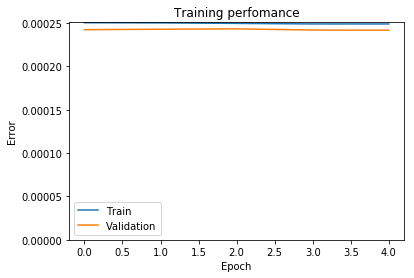

In [14]:
cgnet.train(training_X, training_Y, testing_X, testing_Y, epochs=5)
from neupy import plots
plots.error_plot(cgnet)

In [22]:
from neupy.estimators import rmsle

y_predict = cgnet.predict(testing_X).round(3)

# Root mean square logarithmic error
error = rmsle(data_scaler.inverse_transform(testing_Y), data_scaler.inverse_transform(y_predict))
print(error)

1.2182599245073296


In [38]:
def print_abs_difference_of_predictions(data_scaler, actual_values, predicted_values, slice = 100):
    print(actual_values.shape)
    print(predicted_values.shape)
    actual_values_upscaled = data_scaler.inverse_transform(actual_values)
    predicted_values_upscaled = data_scaler.inverse_transform(predicted_values)

    for itr in range(slice):
        print("#{0}. Diff={1}".format(itr, abs(predicted_values_upscaled[itr] - actual_values_upscaled[itr])))

### SOM using [Neupy](http://neupy.com/apidocs/neupy.algorithms.competitive.sofm.html)

In [41]:
num_epochs = 100
num_clusters = 4
num_features = training_X.shape[1]

In [42]:
# n_inputs is the number of features

sofm = algorithms.SOFM(n_inputs=num_features, n_outputs=num_clusters, step=0.1, learning_radius=0, verbose=True, grid_type='rect')
sofm.train(training_X, epochs=num_epochs)
print(sofm.weight.shape)


Main information

[ALGORITHM] SOFM

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] n_inputs = 27
[OPTION] distance = euclid
[OPTION] features_grid = None
[OPTION] grid_type = rect
[OPTION] learning_radius = 0
[OPTION] n_outputs = 30
[OPTION] reduce_radius_after = 100
[OPTION] reduce_std_after = 100
[OPTION] reduce_step_after = 100
[OPTION] std = 1
[OPTION] weight = Normal(mean=0, std=0.01)


Start training

[TRAINING DATA] shapes: (27750, 27)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |    0.084656 |           - |       6 sec |
|           2 |    0.084348 |           - |       6 sec |
|           3 |    0.084173 |           - |       6 sec |
|           4 |    0.084016 |           - |     

#### Get the predictions for the training set and then get the average of the number of shares for the clusters

In [43]:
trainingX_predictions = sofm.predict(training_X)
cluster_sums = np.zeros(num_clusters)
cluster_counts = np.zeros(num_clusters)
for idx, prediction in enumerate(trainingX_predictions):
    predicted_label = np.argmax(prediction)
    cluster_sums[predicted_label] += training_Y[idx]
    cluster_counts[predicted_label] += 1

#print(cluster_counts)
cluster_averages = cluster_sums/(1+cluster_counts)
print(cluster_averages)

[0.         0.00427217 0.         0.         0.         0.00481474
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00712548 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


#### Get the predictions for the test data

In [44]:
testing_X_predictions = sofm.predict(testing_X)
square_error = 0
predicted_values = []

for idx, prediction in enumerate(testing_X_predictions):
    predicted_label = np.argmax(prediction)
    predicted_shares = cluster_averages[predicted_label]
    predicted_values.append(predicted_shares)
    actual_shares = testing_Y[idx]
    square_error += (predicted_shares-actual_shares)**2

rmse = math.sqrt(square_error/len(testing_X))
print("RMSE: " + str(rmse))

RMSE: 0.015585620463338872


In [45]:
print_abs_difference_of_predictions(data_scaler, testing_Y, np.array(predicted_values).reshape(-1, 1), 30)

(11894, 1)
(11894, 1)
#0. Diff=[1168.23154819]
#1. Diff=[2768.23154819]
#2. Diff=[13631.76845181]
#3. Diff=[2568.23154819]
#4. Diff=[2668.23154819]
#5. Diff=[1168.23154819]
#6. Diff=[3267.23154819]
#7. Diff=[1068.23154819]
#8. Diff=[3068.23154819]
#9. Diff=[3701.23154819]
#10. Diff=[631.76845181]
#11. Diff=[2368.23154819]
#12. Diff=[13731.76845181]
#13. Diff=[13731.76845181]
#14. Diff=[3184.23154819]
#15. Diff=[2568.23154819]
#16. Diff=[3331.76845181]
#17. Diff=[2868.23154819]
#18. Diff=[3455.23154819]
#19. Diff=[3304.23154819]
#20. Diff=[3086.23154819]
#21. Diff=[68.23154819]
#22. Diff=[2168.23154819]
#23. Diff=[468.23154819]
#24. Diff=[4916.85674041]
#25. Diff=[3888.23154819]
#26. Diff=[3543.23154819]
#27. Diff=[2868.23154819]
#28. Diff=[668.23154819]
#29. Diff=[3356.23154819]


In [9]:
def generate_rmse_curves_testing_training_data(hyperparameter_values, validation_rmse, training_rmse, title_text, x_label_text):
    plt.figure()
    plt.xlabel(x_label_text)
    plt.ylabel("RMSE")
    plt.plot(hyperparameter_values, validation_rmse)
    plt.legend(['Test data'])
    